In [ ]:
%reload_ext autoreload
%autoreload 2

# Core imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
import time
import psutil
import os
import sys
import gc
from tqdm import tqdm
from numpy.linalg import cond
import pickle
import json
from datetime import datetime

# GP framework imports
import torch
import gpytorch
from gpytorch import settings as gsettings
from gpytorch.kernels import MultiDeviceKernel
from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
from scipy.sparse.linalg import cg   # SciPy's conjugate gradient solver


# Custom imports
sys.path.append('../../..')
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.utils_sparse import SparseLinearOperator


In [ ]:
# GPyTorch / linear_operator settings
settings.verbose_linalg._default = True
settings._fast_covar_root_decomposition._default = False
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 1
settings.fast_computations.log_prob._state = True
gsettings.num_trace_samples._global_value = 64
gsettings.min_preconditioning_size._global_value = 1e10

In [ ]:
sigma = 0.1
sizes = [2**k for k in range(1, 16)]  # 16, 32, 64, ..., 32k
n_repeats = 10
tolerance = 1e-2

records = []

for N in tqdm(sizes):
    for rep in range(n_repeats):
        np.random.seed(rep)
        torch.manual_seed(rep)

        G = nx.erdos_renyi_graph(n=N, p=2.0 / N, seed=rep)
        csr = nx.to_scipy_sparse_array(G)

        pp = GraphPreprocessor(
            csr,
            walks_per_node=1000,
            p_halt=0.1,
            max_walk_length=5,
            use_tqdm=False,
            n_processes=10,
        )

        step_matrices = pp.preprocess_graph(save_to_disk=False)
        GRF = SparseGRFKernel(max_walk_length=5, step_matrices_torch=step_matrices)

        Phi = GRF._get_feature_matrix()
        A = Phi @ Phi.T + sigma**2 * IdentityLinearOperator(N)
        
        
        if N <= 1024:
            # Compute condition number
            A_dense = A @ torch.eye(N)
            A_np = A_dense.detach().numpy()
            c = cond(A_np)
        else:
            c=None

        # Compute CG iterations
        b = torch.randn(N)
        with torch.no_grad():
            _, k = linear_cg(A._matmul, b, tolerance=tolerance, max_iter=10000, keep_k=True)

        records.append({
            "N": N,
            "repeat": rep,
            "cond": c,
            "iterations": k
        })



In [34]:
df = pd.DataFrame(records)

df.head()

,N,repeat,cond,iterations
0,2,0,141.674225,2
1,2,1,1.170430,2
2,2,2,3227.359131,2
3,2,3,11.952273,2
4,2,4,381.604370,2


In [35]:
df.to_csv("cond_and_iterations_1121.csv", index=False)

<>:76: SyntaxWarning: invalid escape sequence '\k'
<>:76: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_2493758/2621859217.py:76: SyntaxWarning: invalid escape sequence '\k'
  label=f"Fit: $\kappa \sim N^{{{slope_cond:.2f}}}$", alpha=0.8)


Condition number exponent: 0.52


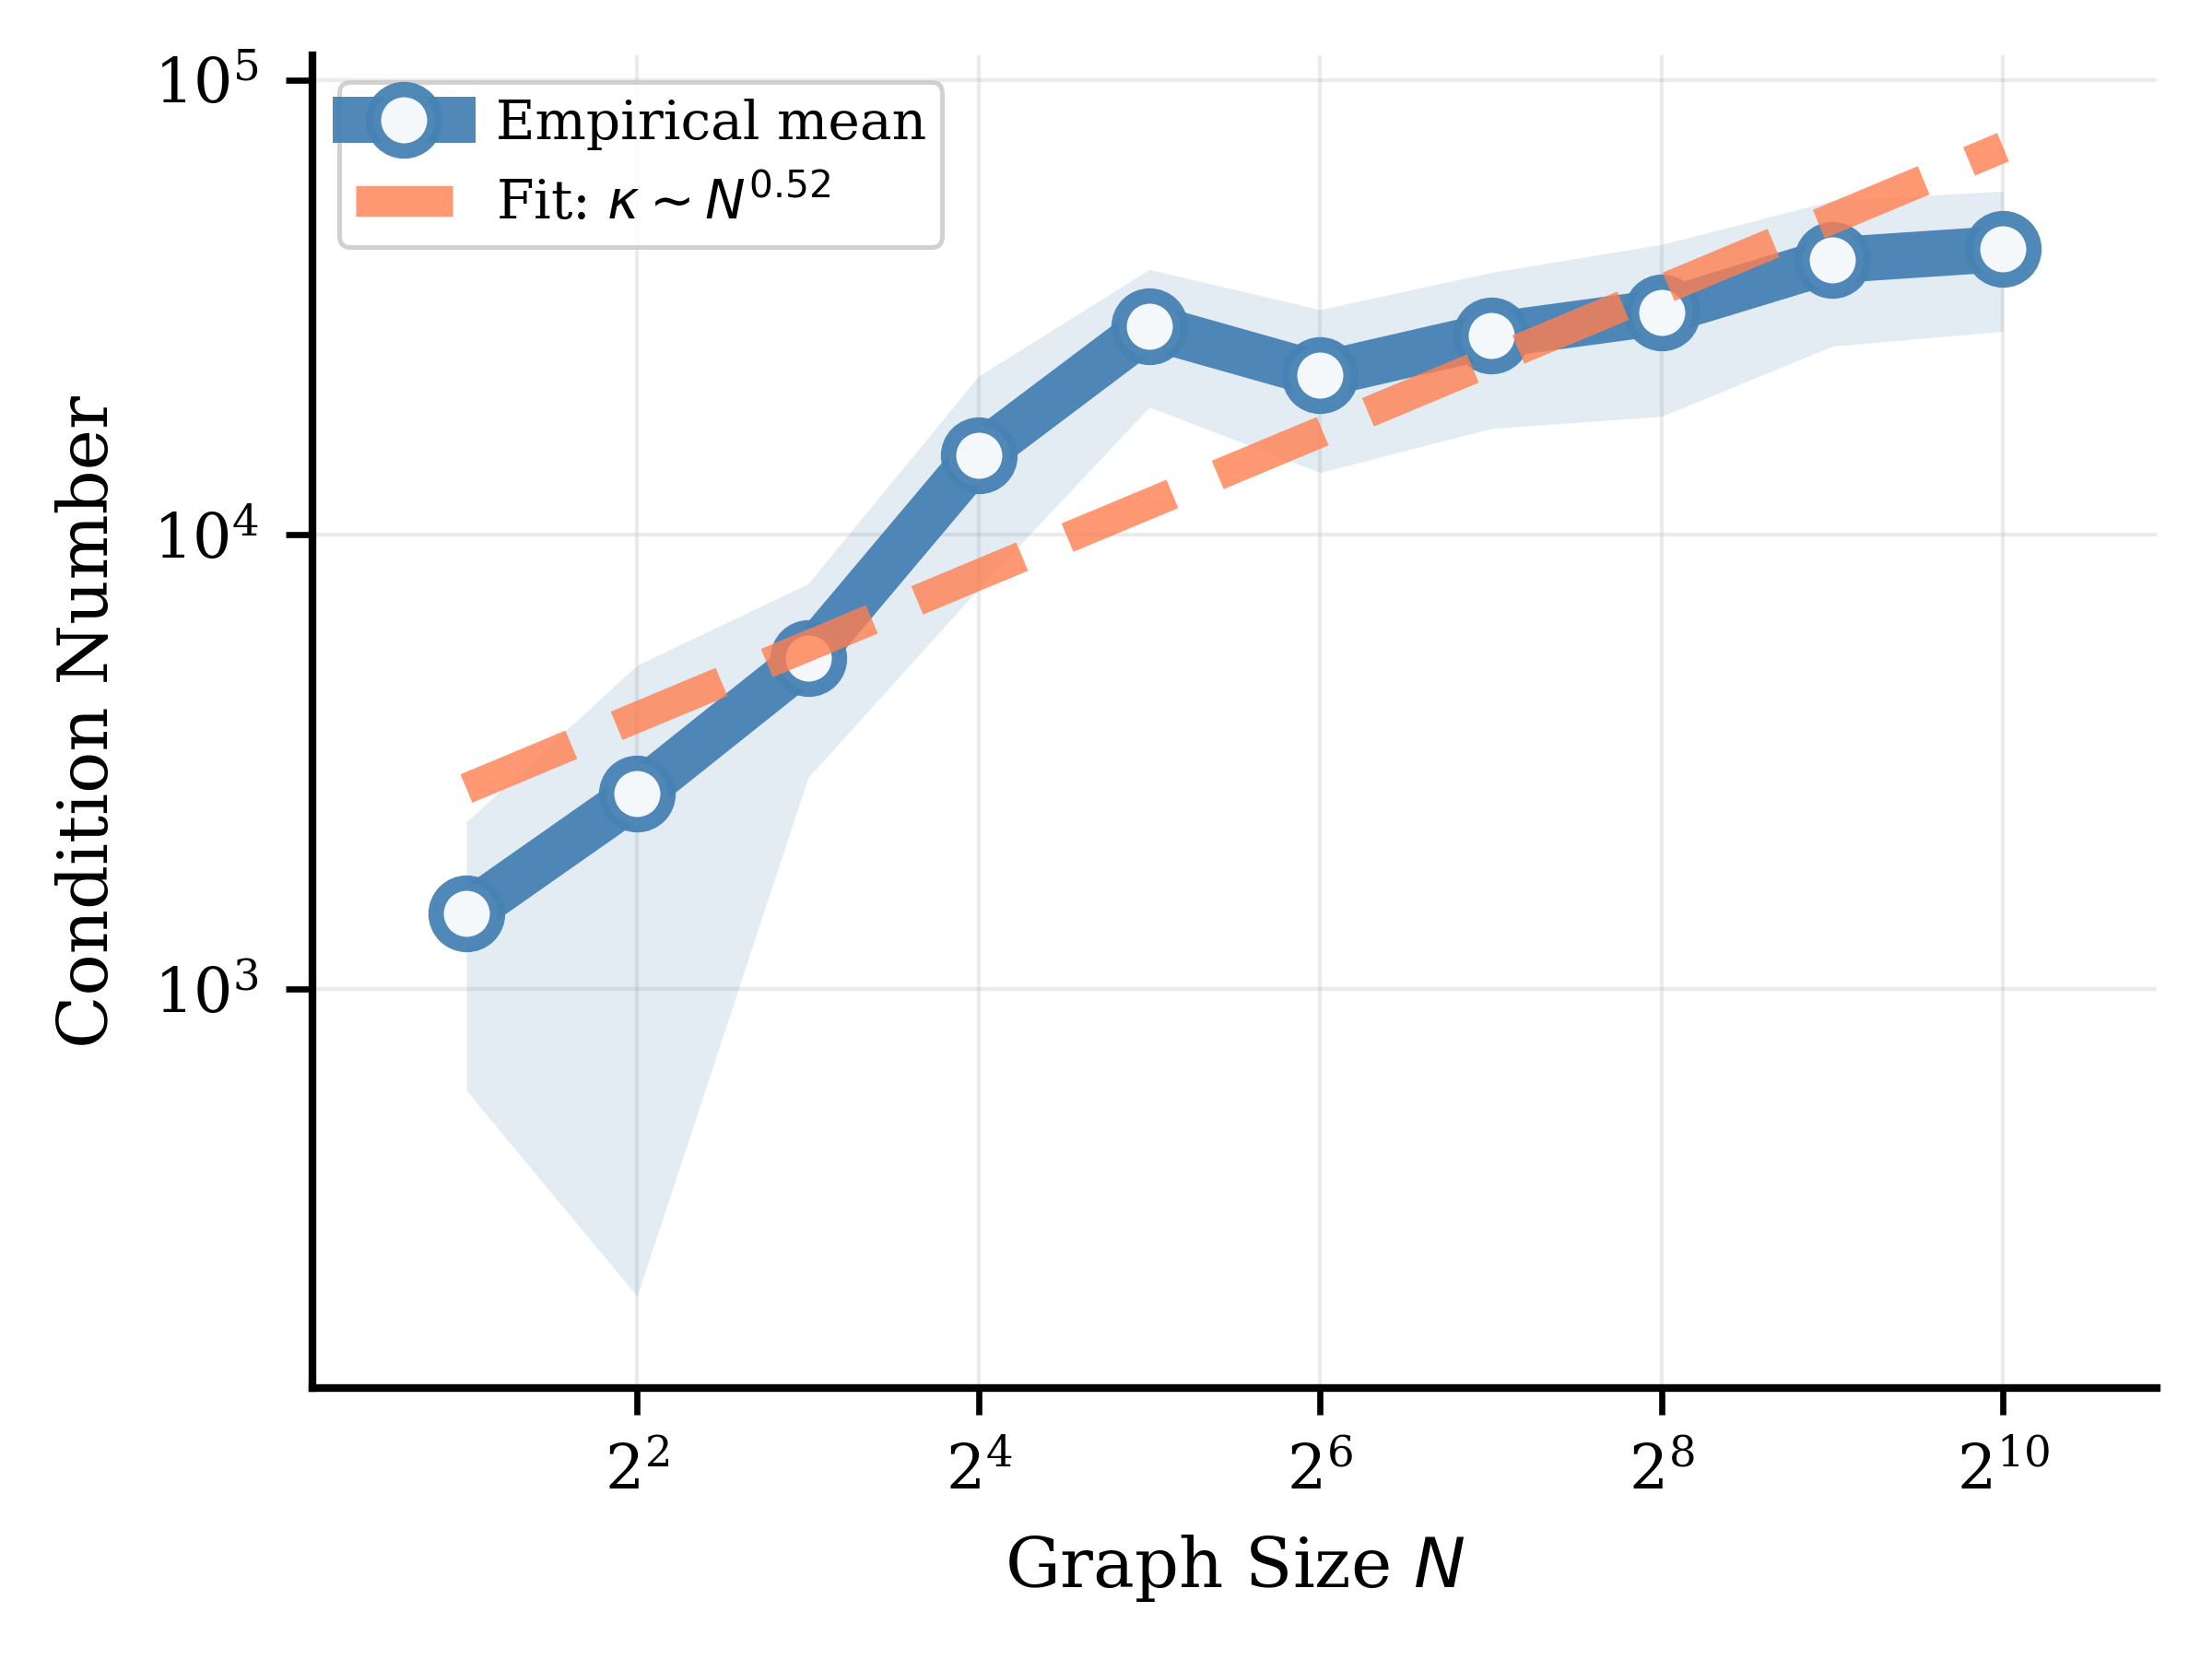

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load the saved results
df = pd.read_csv("cond_and_iterations_1121.csv")

# Filter out rows where condition number is None/NaN
df_cond = df.dropna(subset=['cond'])

# Group results
grouped = df_cond.groupby("N").agg({
    "cond": ["mean", "std"]
}).reset_index()

# Flatten column names
grouped.columns = ['N', 'cond_mean', 'cond_std']

# Fit power laws
x = np.log(grouped["N"].values)
y_cond = np.log(grouped["cond_mean"].values)

slope_cond, intercept_cond = np.polyfit(x, y_cond, 1)

print(f"Condition number exponent: {slope_cond:.2f}")

# Set publication-style formatting
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.25,
    "axes.axisbelow": True,
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

# Plot: Condition Number vs N
fig, ax = plt.subplots(figsize=(4, 3))

# Compute standard error
n_repeats = df_cond.groupby("N").size().iloc[0]
grouped['cond_stderr'] = grouped['cond_std'] / np.sqrt(n_repeats)

ax.fill_between(
    grouped["N"], 
    grouped["cond_mean"] - grouped["cond_stderr"], 
    grouped["cond_mean"] + grouped["cond_stderr"],
    color='steelblue', alpha=0.15, linewidth=0, zorder=1
)

ax.plot(
    grouped["N"], grouped["cond_mean"],
    marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2,
    linestyle='-', linewidth=6, color='steelblue', alpha=0.95,
    label='Empirical mean', zorder=2
)

N_dense = np.linspace(grouped["N"].min(), grouped["N"].max(), 200)
fit_curve_cond = np.exp(intercept_cond) * (N_dense ** slope_cond)
ax.plot(N_dense, fit_curve_cond, '--', linewidth=4, color='coral', 
        label=f"Fit: $\kappa \sim N^{{{slope_cond:.2f}}}$", alpha=0.8)

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Graph Size $N$")
ax.set_ylabel("Condition Number")
ax.grid(True, which="major", axis='both')
ax.grid(False, which="minor")
ax.minorticks_off()

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9,
               fancybox=True, borderpad=0.3, handlelength=1.8)
leg.get_frame().set_linewidth(0.6)
ax.margins(x=0.10, y=0.08)

plt.tight_layout(pad=0.8)
plt.show()

<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2493758/3629323809.py:71: SyntaxWarning: invalid escape sequence '\s'
  label=f"Fit: $k \sim N^{{{slope_iter:.2f}}}$", alpha=0.8)


Iterations exponent: 0.57


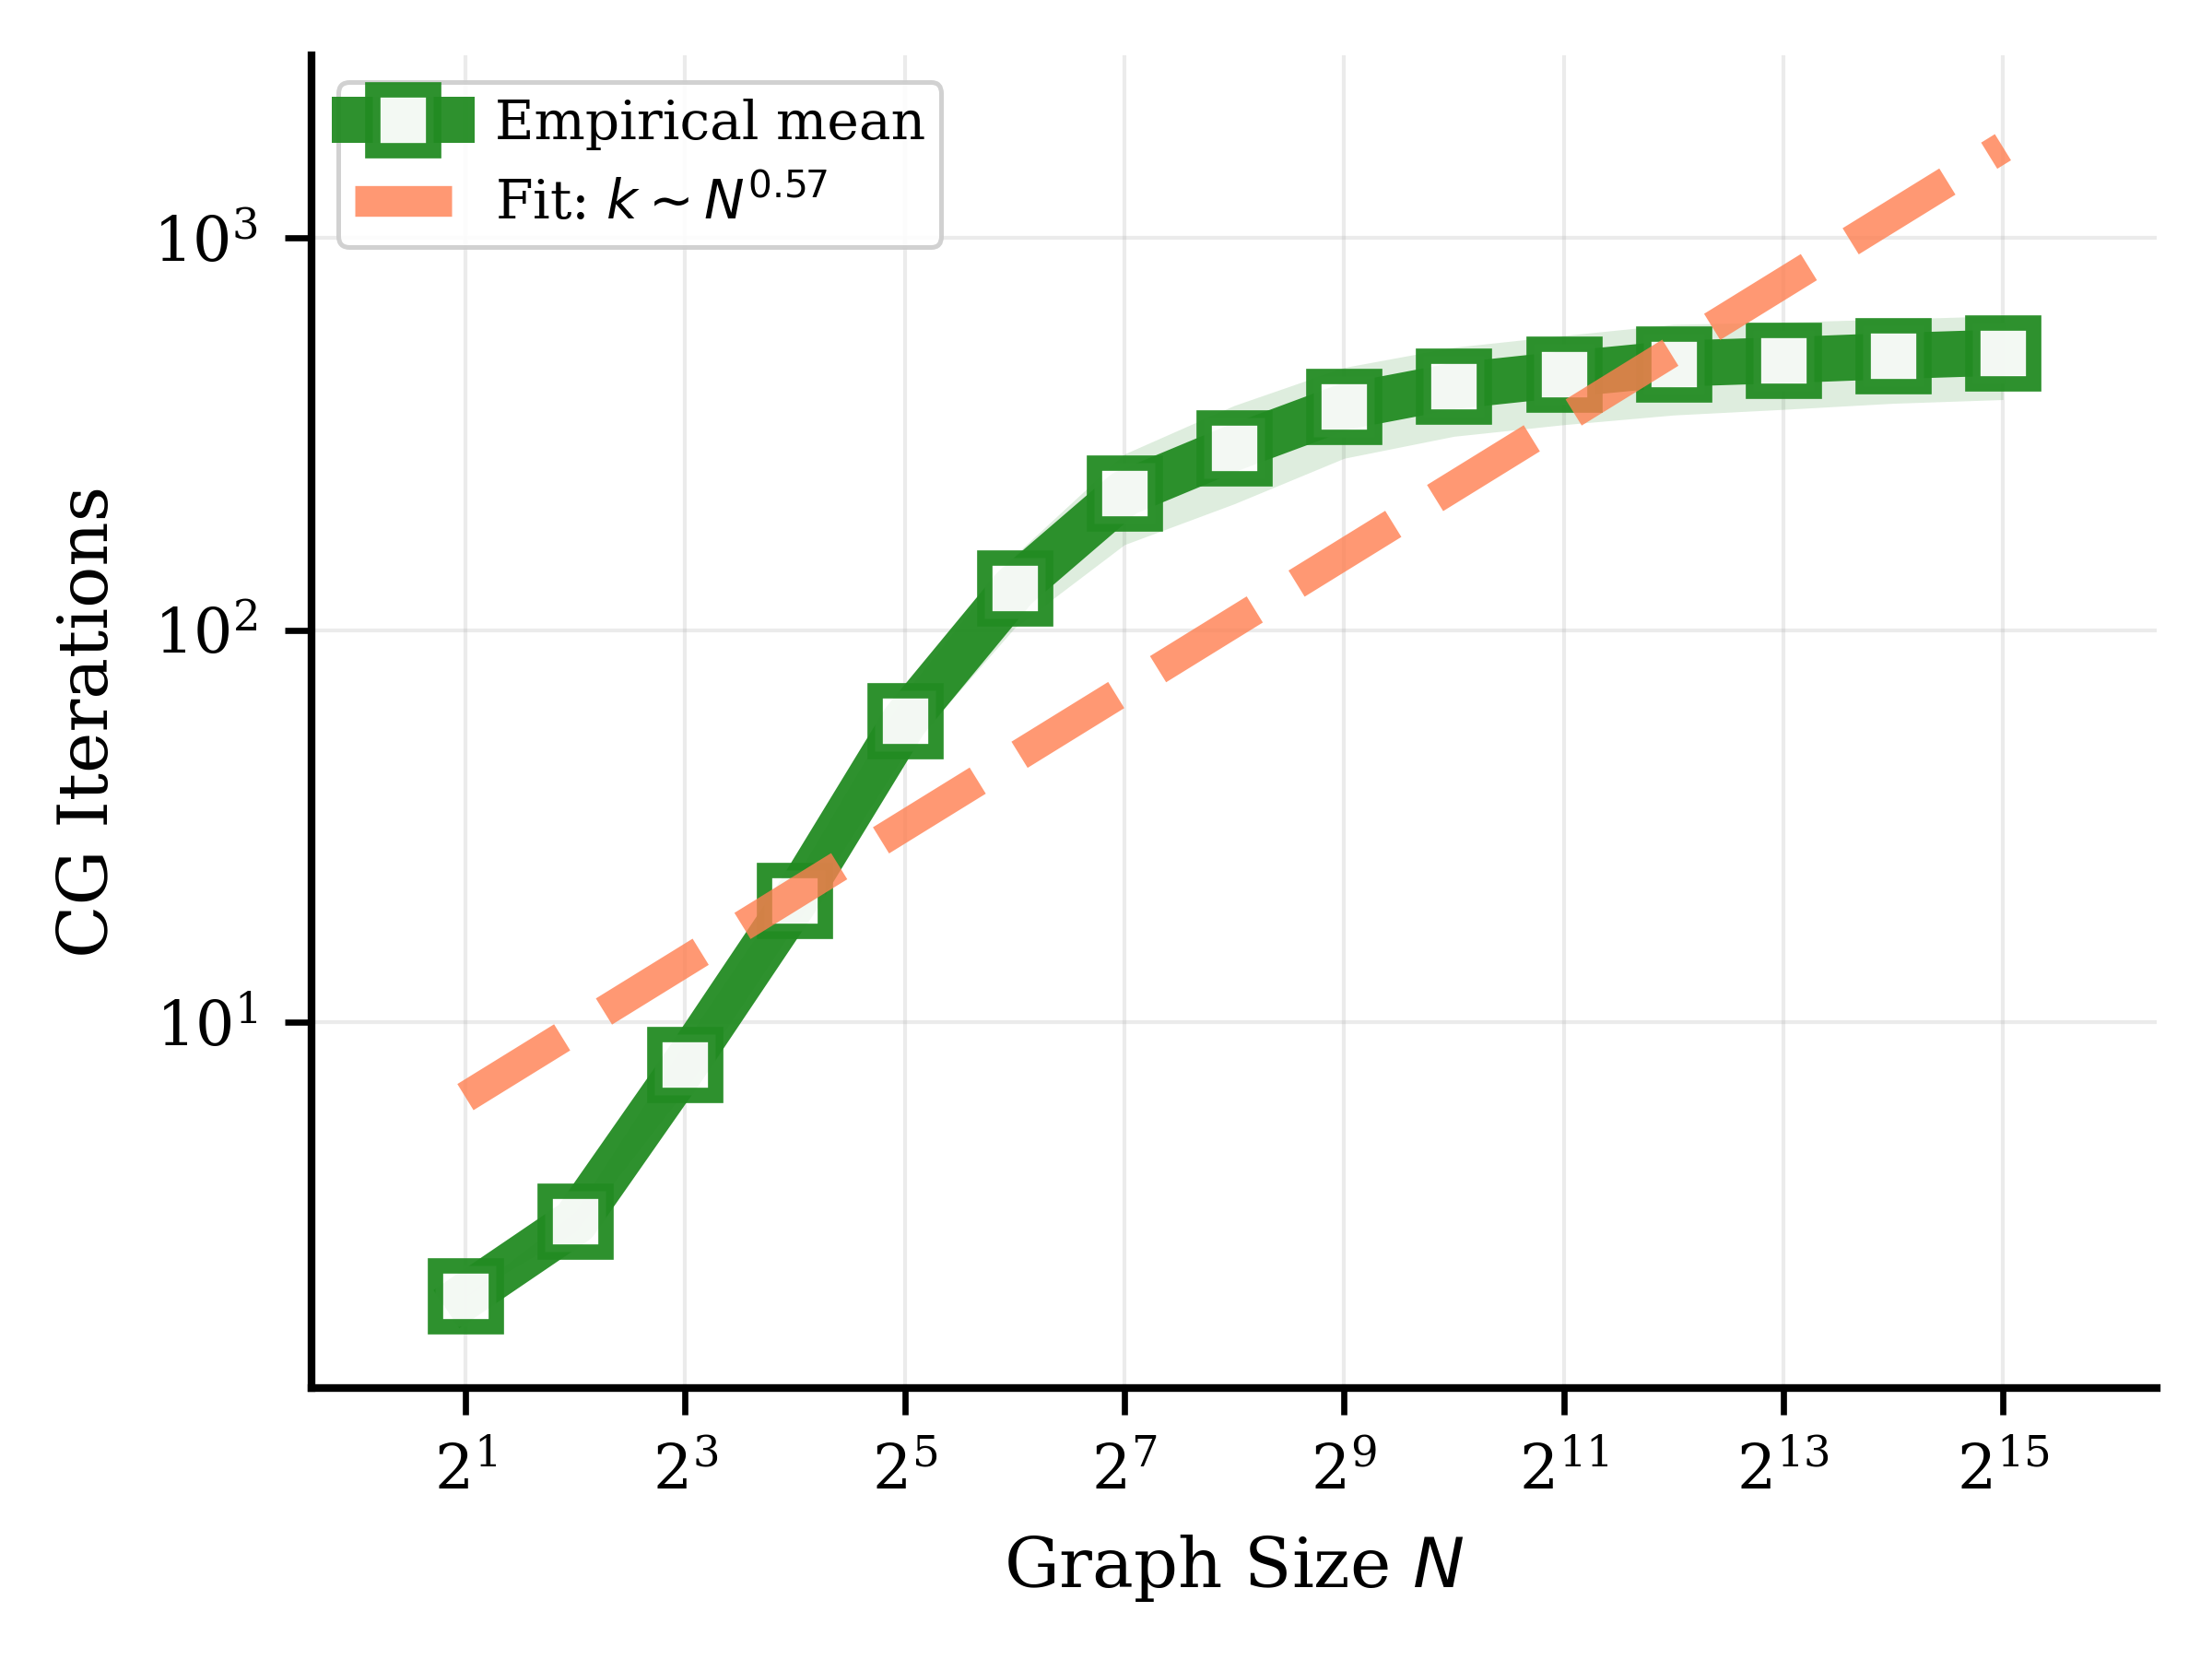

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# Group results
grouped = df.groupby("N").agg({
    "iterations": ["mean", "std"]
}).reset_index()

# Flatten column names
grouped.columns = ['N', 'iter_mean', 'iter_std']

# Fit power law
x = np.log(grouped["N"].values)
y_iter = np.log(grouped["iter_mean"].values)

slope_iter, intercept_iter = np.polyfit(x, y_iter, 1)

print(f"Iterations exponent: {slope_iter:.2f}")

# Set publication-style formatting
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.25,
    "axes.axisbelow": True,
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

# Plot: Iterations vs N
fig, ax = plt.subplots(figsize=(4, 3))

# Compute standard error
n_repeats = df.groupby("N").size().iloc[0]
grouped['iter_stderr'] = grouped['iter_std'] / np.sqrt(n_repeats)

ax.fill_between(
    grouped["N"], 
    grouped["iter_mean"] - grouped["iter_stderr"], 
    grouped["iter_mean"] + grouped["iter_stderr"],
    color='forestgreen', alpha=0.15, linewidth=0, zorder=1
)

ax.plot(
    grouped["N"], grouped["iter_mean"],
    marker='s', markersize=8, markerfacecolor='white', markeredgewidth=2,
    linestyle='-', linewidth=6, color='forestgreen', alpha=0.95,
    label='Empirical mean', zorder=2
)

N_dense = np.linspace(grouped["N"].min(), grouped["N"].max(), 200)
fit_curve_iter = np.exp(intercept_iter) * (N_dense ** slope_iter)
ax.plot(N_dense, fit_curve_iter, '--', linewidth=4, color='coral', 
        label=f"Fit: $k \sim N^{{{slope_iter:.2f}}}$", alpha=0.8)

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Graph Size $N$")
ax.set_ylabel("CG Iterations")
ax.grid(True, which="major", axis='both')
ax.grid(False, which="minor")
ax.minorticks_off()

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9,
               fancybox=True, borderpad=0.3, handlelength=1.8)
leg.get_frame().set_linewidth(0.6)
ax.margins(x=0.10, y=0.08)

plt.tight_layout(pad=0.8)
plt.show()

<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\k'
<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_2493758/4180984497.py:52: SyntaxWarning: invalid escape sequence '\s'
  label=f"Fit: $k \sim \kappa^{{{slope:.2f}}}$", alpha=0.8)
/tmp/ipykernel_2493758/4180984497.py:56: SyntaxWarning: invalid escape sequence '\k'
  ax.set_xlabel("Condition Number $\kappa$")


Iterations vs Condition Number exponent: 0.53


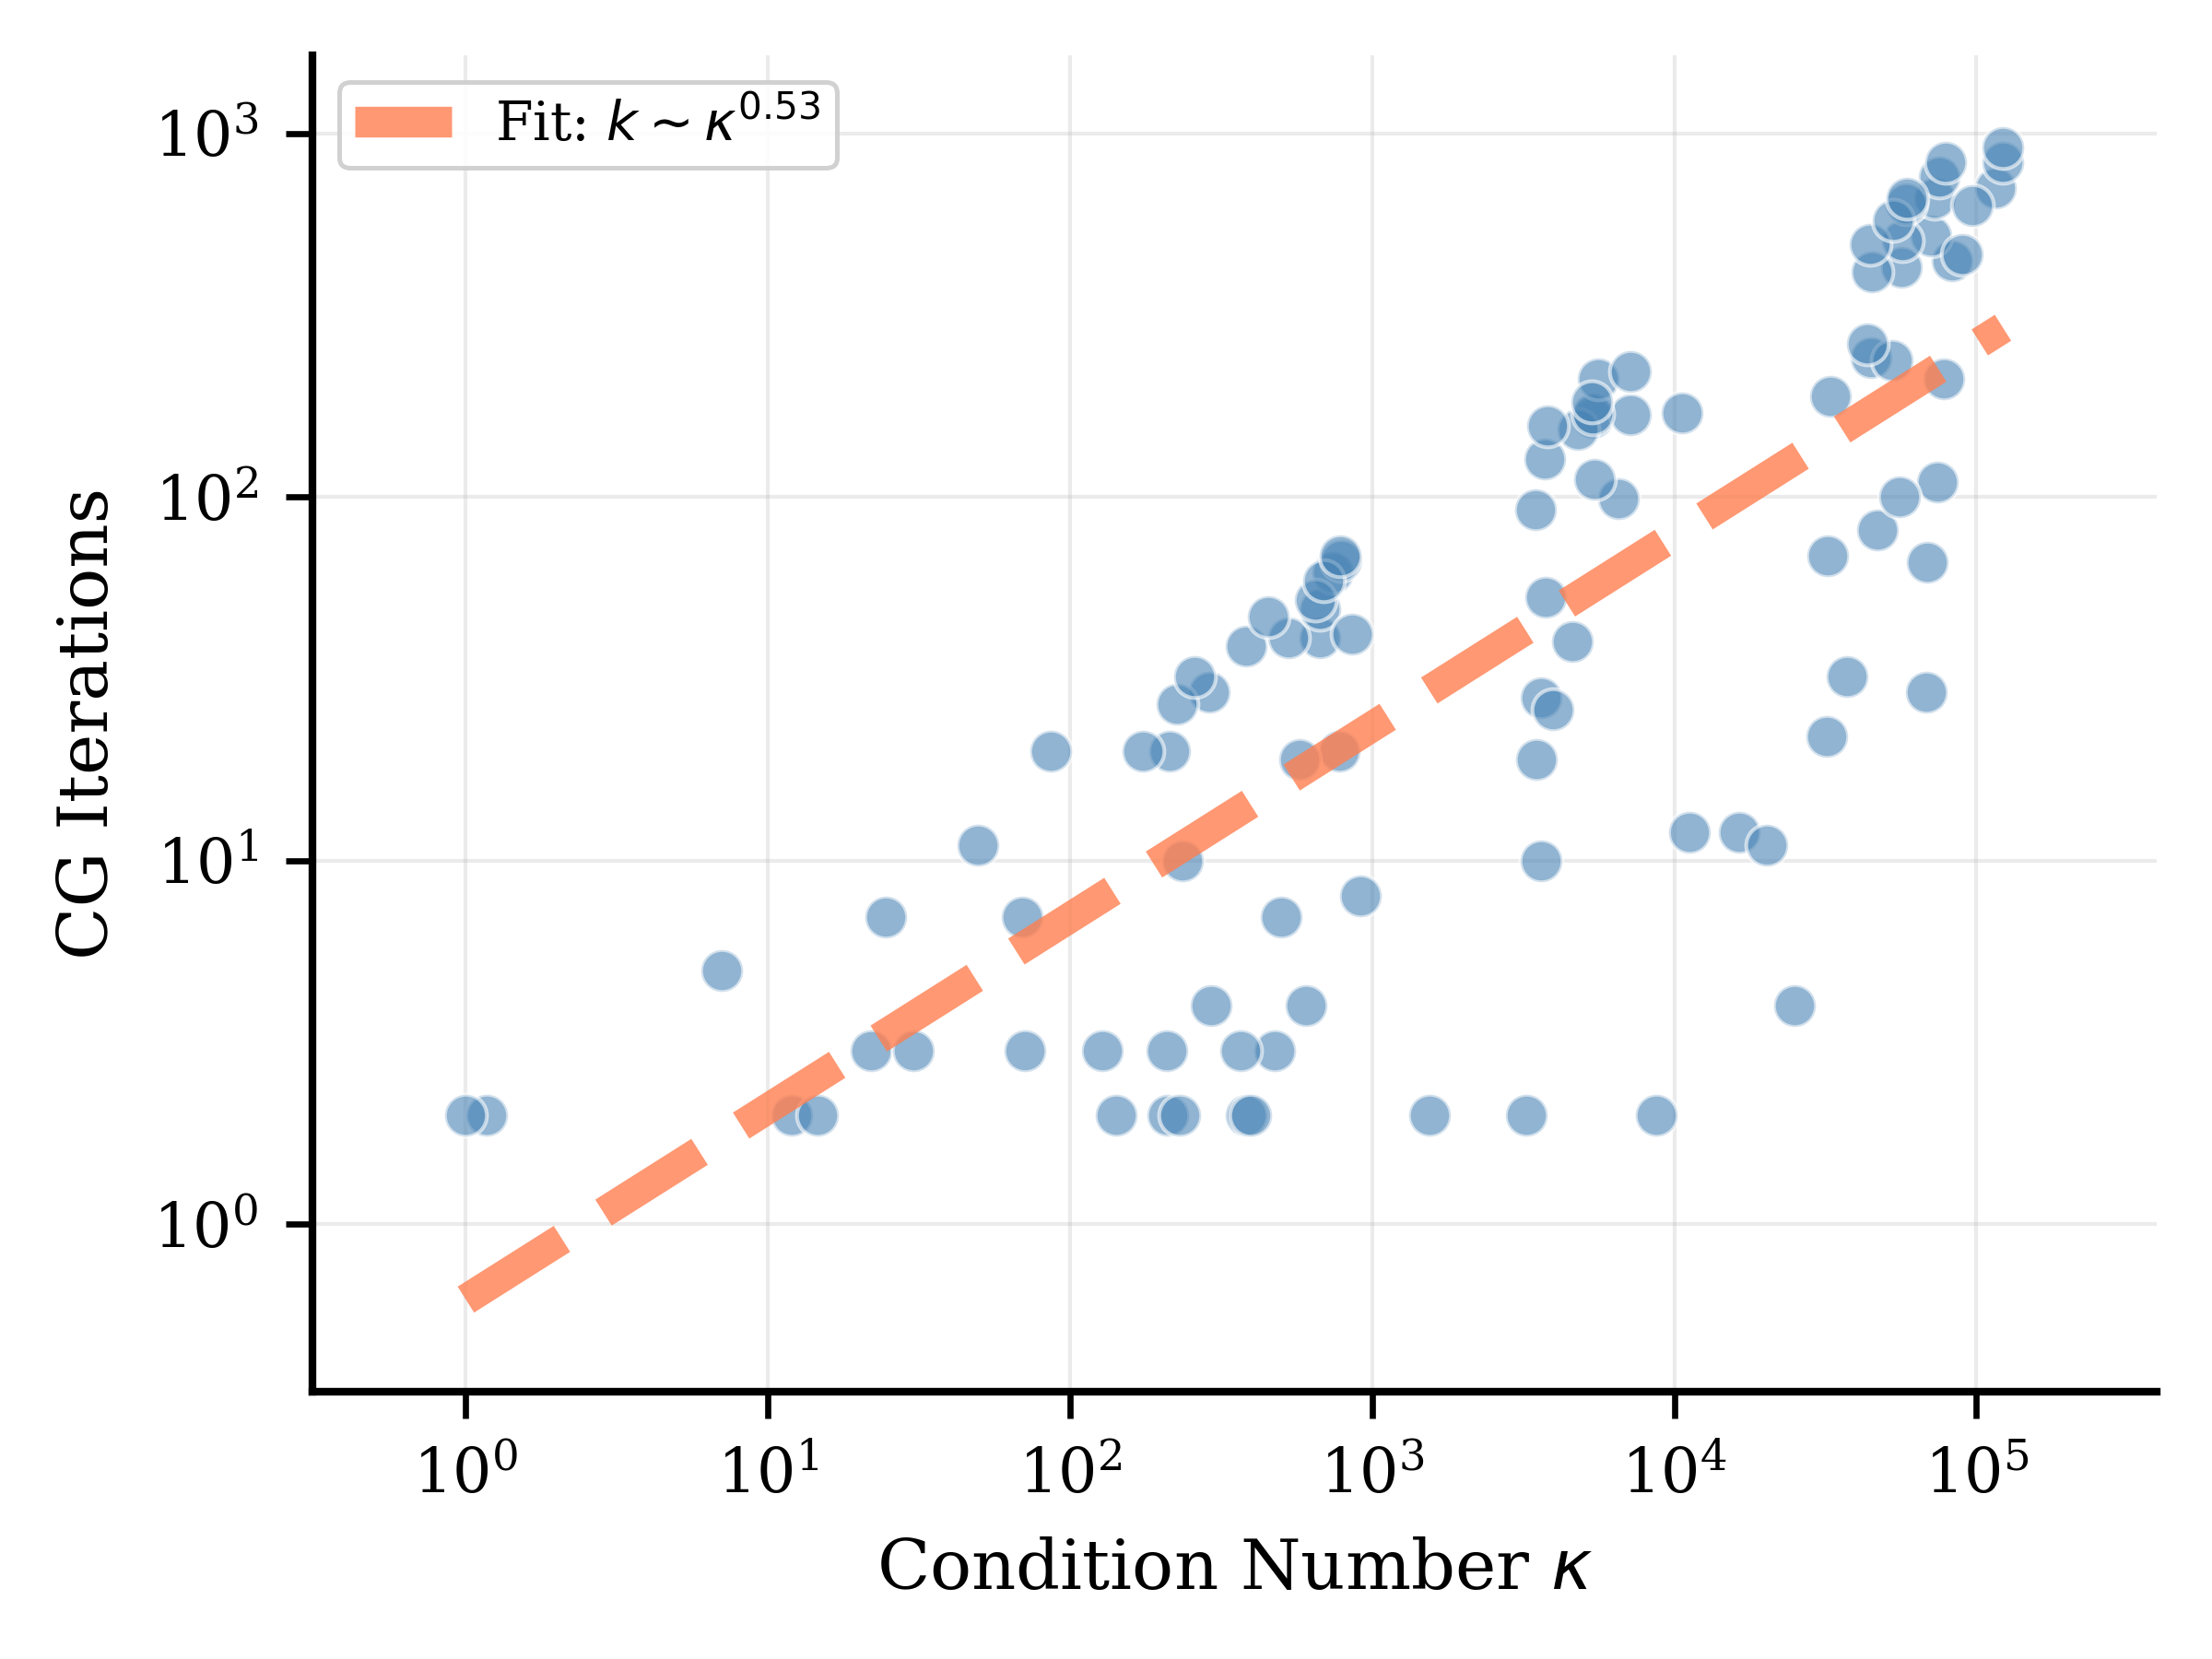

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# Filter out rows where condition number is None/NaN
df_valid = df.dropna(subset=['cond'])

# Set publication-style formatting
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.25,
    "axes.axisbelow": True,
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

# Plot iterations vs condition number
fig, ax = plt.subplots(figsize=(4, 3))

# Scatter all data points
ax.scatter(df_valid["cond"], df_valid["iterations"], 
          s=30, alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)

# Fit line in log-log space
x_log = np.log(df_valid["cond"].values)
y_log = np.log(df_valid["iterations"].values)
slope, intercept = np.polyfit(x_log, y_log, 1)

print(f"Iterations vs Condition Number exponent: {slope:.2f}")

# Plot fit
cond_dense = np.linspace(df_valid["cond"].min(), df_valid["cond"].max(), 200)
fit_curve = np.exp(intercept) * (cond_dense ** slope)
ax.plot(cond_dense, fit_curve, '--', linewidth=4, color='coral',
       label=f"Fit: $k \sim \kappa^{{{slope:.2f}}}$", alpha=0.8)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Condition Number $\kappa$")
ax.set_ylabel("CG Iterations")
ax.grid(True, which="major", axis='both')
ax.grid(False, which="minor")
ax.minorticks_off()

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9,
               fancybox=True, borderpad=0.3, handlelength=1.8)
leg.get_frame().set_linewidth(0.6)

ax.margins(x=0.10, y=0.08)
plt.tight_layout(pad=0.8)
plt.show()